# OLAP Support in SQL

In [ ]:
import pandas as pd
from pandas import DataFrame
from data201 import db_connection, df_query

pd.set_option('display.max_rows', None)

In [ ]:
conn = db_connection(config_file='students.ini')
cursor = conn.cursor()

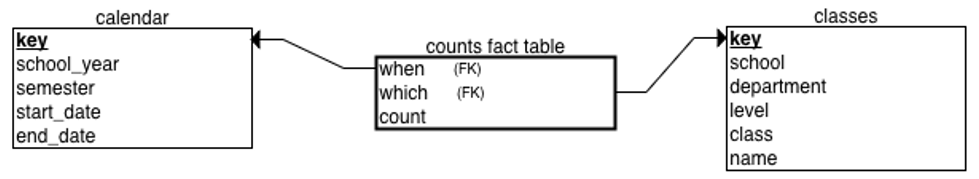

## `calendar` dimension
#### Hierarchy: `school_year`, `semester`

In [ ]:
df_query(conn, 'SELECT * FROM calendar')

## `classes` dimension
#### Hierarchy: `school`, `department`, `level`, `class`

In [ ]:
df_query(conn, 'SELECT * FROM classes')

## `counts` fact table
#### Measure: `count` of students<br>Foreign key to the `calendar` dimension: `when`<br>Foreign key to the `class` dimension: `which`

In [ ]:
df_query(conn, 'SELECT * FROM counts')

## Join the `counts` fact table with the dimension tables

In [ ]:
df_query(conn, 
    """
    SELECT school_year, semester, YEAR(start_date) AS year, 
           start_date, end_date, 
           school, department, level, class, name, count
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    ORDER BY school_year, semester, school, department, level, class
    """
)

# Slice: DATA 201 only
#### To slice, hold one attribute of the `classes` dimension constant:
``` SQL
classes.class = 'DATA 201'
```

In [ ]:
df_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    WHERE classes.class = 'DATA 201'
    """
)

# Slice: Spring semester only
#### To slice, hold one attribute of the `calendar` dimension constant:
``` SQL
calendar.semester = 'spring'
```

In [ ]:
df_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    WHERE calendar.semester = 'spring'
    """
)

# Dice: Graduate students in the schools of Information and Science during spring and fall semesters
#### To dice: Use a range of values in each of the `classes` and `calendar` dimensions:
``` SQL
WHERE classes.level = 'graduate'
  AND classes.school IN ('Information', 'Science') 
  AND calendar.semester IN ('spring', 'fall')
```

In [ ]:
df_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    WHERE classes.level = 'graduate'
      AND classes.school IN ('Information', 'Science') 
      AND calendar.semester IN ('spring', 'fall')
    ORDER BY school_year, semester, school, department, level, class
    """
)

## Drill downs for subtotaling

### Grand total student count

In [ ]:
df_query(conn, 
    """
    SELECT SUM(count)
    FROM counts
    """
)

### Rollup: Student count subtotals by school year

In [ ]:
df_query(conn, 
    """
    SELECT school_year,
           SUM(count) AS yearly_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    GROUP BY school_year
    ORDER BY school_year

    """
)

### Rollup: Student count subtotals by school year and semester

In [ ]:
df_query(conn, 
    """
    SELECT school_year, semester,
           SUM(count) AS semester_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    GROUP BY school_year, semester
    ORDER BY school_year, semester

    """
)

### Rollup: Student count subtotals by school year, semester, and school

In [ ]:
df_query(conn, 
    """
    SELECT school_year, semester, school,
           SUM(count) AS school_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    GROUP BY school_year, semester, school
    ORDER BY school_year, semester, school

    """
)

### Rollup: Student count subtotals by school year, semester, school, and department

In [ ]:
df_query(conn, 
    """
    SELECT school_year, semester, school, department,
           SUM(count) AS department_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    GROUP BY school_year, semester, school, department
    ORDER BY school_year, semester, school, department

    """
)

### Student count subtotals by school year, semester, school, department, and level

In [ ]:
df_query(conn, 
    """
    SELECT school_year, semester, school, department, level,
           SUM(count) AS level_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    GROUP BY school_year, semester, school, department, level
    ORDER BY school_year, semester, school, department, level

    """
)

## Window functions
#### We use window functions to display all the subtotals and the grand total.

In [ ]:
df_query(conn, 
    """
    SELECT DISTINCT 
        school_year, semester, school, department, level,
        SUM(count) OVER() 
            AS grand_total,
        SUM(count) OVER(PARTITION BY school_year) 
            AS yearly_total,
        SUM(count) OVER(PARTITION BY school_year, semester) 
            AS semester_total,
        SUM(count) OVER(PARTITION BY school_year, semester, school) 
            AS school_total,
        SUM(count) OVER(PARTITION BY school_year, semester, 
                                    school, department) 
            AS dept_total,
        SUM(count) OVER(PARTITION BY school_year, semester, 
                                    school, department, level) 
            AS level_total
    FROM counts
    JOIN calendar
      ON counts.when = calendar.key
    JOIN classes
      ON counts.which = classes.key
    ORDER BY school_year, semester, school, department, level
    """
)

In [ ]:
cursor.close()
conn.close()